In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.io.fits as pyfits
import time
from lenstronomy.Util import constants as const
import lenstronomy.Util.param_util as param_util
import pickle
import corner    
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Analysis.td_cosmography import TDCosmography
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData

In [2]:
#Create function to use later
def cal_Ddt(zl, zs, H0_ini=100, om=0.27):
    cosmo = FlatLambdaCDM(H0=H0_ini, Om0=0.27) 
    lensunits=LensCosmo(z_lens=zl, z_source=zs,cosmo= cosmo)
    D_l=lensunits.dd
    D_s=lensunits.ds
    D_ls=lensunits.dds
    Ddt_corr = (1+zl)*D_l*D_s/D_ls
    return Ddt_corr

def cal_h0(zl, zs, Ddt, om=0.27):  #Quickly calculate H0 known a Dt, zl, zs.
    Ddt_corr = cal_Ddt(zl, zs, H0_ini=100)
    ratio = Ddt_corr/Ddt
    return 100 * ratio

import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage            

#A function to automaticlly find QSO position and to put as lensed QSO positions.
def find_loc_max(data, neighborhood_size = 4, threshold = 5): 
    neighborhood_size = neighborhood_size
    threshold = threshold
    data_max = filters.maximum_filter(data, neighborhood_size) 
    maxima = (data == data_max)
    data_min = filters.minimum_filter(data, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0
    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    x, y = [], []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        x.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2    
        y.append(y_center)
    return x, y

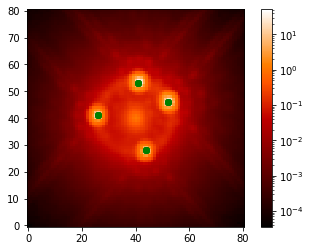

In [3]:
#This box is to set up the fitting settings:
folder = 'ID718' + '/'

#Load the parameters and settings used in the simulation:
model_lists, para_s, lens_info= pickle.load(open(folder+'simulation_paras.pkl','rb')) 
lens_model_list, lens_light_model_list, source_model_list, point_source_list = model_lists
z_l, z_s, TD_distance, TD_true, TD_obs, TD_err_l = lens_info
kwargs_lens_list, kwargs_lens_light_list, kwargs_source_list, kwargs_ps = para_s  

solver_type = 'PROFILE_SHEAR'
kwargs_constraints = {#'joint_source_with_point_source': [[0, 0]],
                      'num_point_source_list': [len(kwargs_ps['ra_image'])],
                      'solver_type': solver_type,  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                      'Ddt_sampling': True
                              }

exp_time = 599.* 2 * 8  #2 long exposure time and 8 dither frame
deltaPix = 0.08

lens_data = pyfits.getdata(folder+'Drz_QSO_image.fits')
len_std = pyfits.getdata(folder+'noise_map.fits')
lens_mask = pyfits.getdata(folder+'noise_map.fits')

x, y =find_loc_max(lens_data)
center = (len(lens_data)-1)/2

QSO_pos= []
for i in range(len(x)):
    QSO_pos.append([float(x[i]-0.5), float(y[i]-0.5)])
xy_index = np.indices((len(lens_data),len(lens_data)))

count = 0
for i in range(len(x)):
    x0, y0 =  (float(x[i]) - center) * deltaPix , (float(y[i]) - center) * deltaPix
    ds = (x0- kwargs_ps['ra_image'] )**2 + (y0-kwargs_ps['dec_image'])**2
    if ds.min()<0.01:
        kwargs_ps['ra_image'][ds == ds.min()] = x0
        kwargs_ps['dec_image'][ds == ds.min()] = y0
        count += 1
        # #Boost central noise if want to test.
        # if count == 0:
        #     areas = (np.sqrt((QSO_pos[i][1]-xy_index[0])**2+(QSO_pos[i][0]-xy_index[1])**2) <3. )  # five piexls
        # else:
        #     areas += (np.sqrt((QSO_pos[i][1]-xy_index[0])**2+(QSO_pos[i][0]-xy_index[1])**2) <3. )  # five piexls
# len_std = len_std * (areas == 0) + 10**6 * (areas != 0)
# plt.imshow(len_std, origin='low', norm=LogNorm(), vmax = 0.2)
# plt.show()                

#Plot the fitting image:
plt.imshow(lens_data * lens_mask, origin='lower',cmap='gist_heat', norm=LogNorm())
plt.colorbar()
if count!= len(kwargs_ps['ra_image']):
    raise ValueError("the PS positions is not assigned correctly")
for i in range(len(kwargs_ps['ra_image'])):
    plt.plot(kwargs_ps['ra_image']/deltaPix+center, kwargs_ps['dec_image']/deltaPix+center, 'go')
plt.show()         

kwargs_data = sim_util.data_configure_simple(numPix = len(lens_data), deltaPix = deltaPix) #,inverse=True)
kwargs_data['image_data'] = lens_data
kwargs_data['noise_map'] = len_std

psf = pyfits.getdata(folder+'Drz_PSF.fits')
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf, 'pixel_size': deltaPix, 
              'psf_error_map': np.ones_like(psf)*0.01}  # Set PSF uncertainty as 10%, (10% **2 = 0.01)
psf_class = PSF(**kwargs_psf)

In [4]:
#Setting up the parameters and fitting details
# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []
fixed_lens.append({}) 
fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init = kwargs_lens_list
kwargs_lens_sigma.append({'theta_E': .2, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': kwargs_lens_init[0]['gamma']-0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': kwargs_lens_init[0]['gamma']+0.5, 'center_x': 10, 'center_y': 10})
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.1})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})
lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []
kwargs_lens_light_init = kwargs_lens_light_list
fixed_lens_light.append({})
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

# source model choices
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []
fixed_source.append({})
kwargs_source_init = kwargs_source_list
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})
source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

# point source choices
fixed_ps = [{}]
kwargs_ps_init = [kwargs_ps]
#        kwargs_ps_init = kwargs_result['kwargs_ps']
kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(kwargs_ps_init[0]['ra_image'])), 'dec_image': 0.01 * np.ones(len(kwargs_ps_init[0]['ra_image']))}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(kwargs_ps_init[0]['ra_image'])), 'dec_image': -10 * np.ones(len(kwargs_ps_init[0]['ra_image']))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(kwargs_ps_init[0]['ra_image'])), 'dec_image': 10 * np.ones(len(kwargs_ps_init[0]['ra_image']))}]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

# Set cosmo
fixed_special = {}
kwargs_special_init = {}
kwargs_special_sigma = {}
kwargs_lower_special = {}
kwargs_upper_special = {}
kwargs_special_init = {'D_dt': TD_distance}
kwargs_special_sigma = {'D_dt': 500}
kwargs_lower_special = {'D_dt': TD_distance/2}
kwargs_upper_special = {'D_dt': TD_distance*1.5}
#Suggested by Simon: 
astrometry_sigma = 0.005
ximg, yimg = kwargs_ps_init[0]['ra_image'], kwargs_ps_init[0]['dec_image']
kwargs_special_init['delta_x_image'], kwargs_special_init['delta_y_image'] = np.zeros_like(ximg), np.zeros_like(yimg)
kwargs_special_sigma['delta_x_image'], kwargs_special_sigma['delta_y_image'] = np.ones_like(ximg) * astrometry_sigma, np.ones_like(yimg) * astrometry_sigma
kwargs_lower_special['delta_x_image'], kwargs_lower_special['delta_y_image'] = np.ones_like(ximg) * (-1), np.ones_like(yimg) * (-1)
kwargs_upper_special['delta_x_image'], kwargs_upper_special['delta_y_image'] = np.ones_like(ximg) * (1), np.ones_like(yimg) * (1)
special_params = [kwargs_special_init, kwargs_special_sigma, fixed_special, kwargs_lower_special, kwargs_upper_special]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params,
                'special': special_params,
                'point_source_offset': True}

# numerical options and fitting sequences
num_source_model = len(source_model_list)

kwargs_likelihood = {'check_bounds': True,
                      'force_no_add_image': False,
                      'source_marg': False,
                      'image_position_uncertainty': astrometry_sigma,
                      'astrometric_likelihood': True,
                      'check_matched_source_position': True,
                      'source_position_tolerance': 0.01,
                      'time_delay_likelihood': True,
                      'image_likelihood_mask_list': [lens_mask]
                              }
kwargs_numerics = {'supersampling_factor': 3}
image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear',
                    'time_delays_measured': TD_obs[1:],
                    'time_delays_uncertainties': TD_err_l[1:]}

kwargs_model = {'lens_model_list': lens_model_list, 
                  'lens_light_model_list': lens_light_model_list,
                  'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                  }

In [5]:
#Perform fitting:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints,
                              kwargs_likelihood, kwargs_params)

start_time = time.time()
fitting_kwargs_list_0 = [
                        ['PSO', {'sigma_scale': 1., 'n_particles': 150, 'n_iterations': 200}],
                        ['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 400}],
                        ['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 400}]
                        ]

fitting_seq.fit_sequence(fitting_kwargs_list_0)

kwargs_psf_iter = {'num_iter': 150, 'psf_iter_factor': 0.5,
                    'stacking_method': 'median', 
                    'keep_psf_error_map': True, 
                    'psf_symmetry': 1, 
                    'block_center_neighbour': 0.05}

# kwargs_psf_iter = {'num_iter': 150, 'psf_iter_factor': 0.5,
#                     'stacking_method': 'median', 
#                     'keep_psf_error_map': False, 
#                     'psf_symmetry': 1, 
#                     'block_center_neighbour': 0.05}        

fitting_kwargs_list = [
                        ['psf_iteration', kwargs_psf_iter],
                        ['PSO', {'sigma_scale': 1., 'n_particles': 150, 'n_iterations': 300}],
                        ['psf_iteration', kwargs_psf_iter],
                        ['PSO', {'sigma_scale': .1, 'n_particles': 150, 'n_iterations': 300}],
                        ['MCMC', {'n_burn': 300, 'n_run': 400, 'walkerRatio': 6, 'sigma_scale': 0.1}],
                        ]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result_best = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')


/Users/Dartoon/anaconda2/envs/astroconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Computing the PSO ...


/Users/Dartoon/anaconda2/envs/astroconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.9185022320156377 reduced X^2 of best position
-3000.7467919950886 logL
6534 effective number of data points
[{'theta_E': 1.0825336261303997, 'gamma': 1.9660727524951604, 'e1': -0.052977203351411484, 'e2': -0.02752144982278253, 'center_x': 0.0017473024846084318, 'center_y': 0.002123605838488012}, {'gamma1': 0.007210738007308729, 'gamma2': -0.005737825152695904, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.34201303835591884, 'n_sersic': 1.8669935321772646, 'e1': -0.006238233588000053, 'e2': 0.06894827010473564, 'center_x': -0.020075382238828557, 'center_y': 0.02370193261509447}] source result
[{'amp': 1, 'R_sersic': 0.8367058684845213, 'n_sersic': 2.670984097240386, 'e1': -0.048560901828993794, 'e2': -0.009871875957089223, 'center_x': 0.0024420377651164357, 'center_y': 0.002767376102703014}] lens light result
[{'ra_image': array([-1.12875223,  0.98084017,  0.0967069

100%|██████████| 700/700 [57:24<00:00,  4.92s/it] 

Computing the MCMC...
Number of walkers =  144
Burn-in iterations:  300
Sampling iterations (in current run): 700
3450.1594047546387 time taken for MCMC sampling
12042.45439004898 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


In [6]:
#Translate the fitting outputs and save as pickle.
fix_setting =  [fixed_lens, fixed_source, fixed_lens_light, fixed_ps, fixed_special]
param = Param(kwargs_model, fixed_lens, fixed_source, fixed_lens_light, fixed_ps, fixed_special, 
              kwargs_lens_init=kwargs_result_best['kwargs_lens'], **kwargs_constraints)
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[-1]
mcmc_new_list = []
labels_new = [r"$\gamma$", r"$D_{\Delta t}$","H$_0$" ]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result = param.args2kwargs(samples_mcmc[i])
    D_dt = kwargs_result['kwargs_special']['D_dt']
    gamma = kwargs_result['kwargs_lens'][0]['gamma']
    mcmc_new_list.append([gamma, D_dt, cal_h0(z_l ,z_s, D_dt)])       

#Save in pickle
savename = 'savepkl.pkl'    
pickle.dump([multi_band_list, kwargs_model, kwargs_result, chain_list, fix_setting, mcmc_new_list], open(folder+savename, 'wb'))

-0.6471302044500776 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.6471302044500775


/Users/Dartoon/.local/lib/python3.6/site-packages/lenstronomy-1.6.0-py3.6.egg/lenstronomy/Plots/model_band_plot.py:551: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
/Users/Dartoon/anaconda2/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


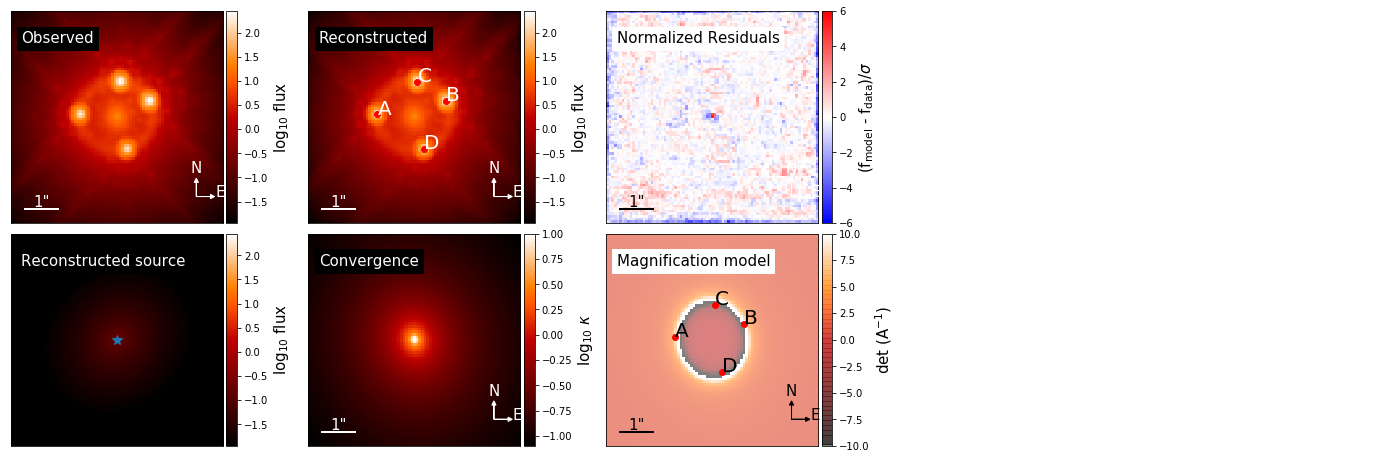

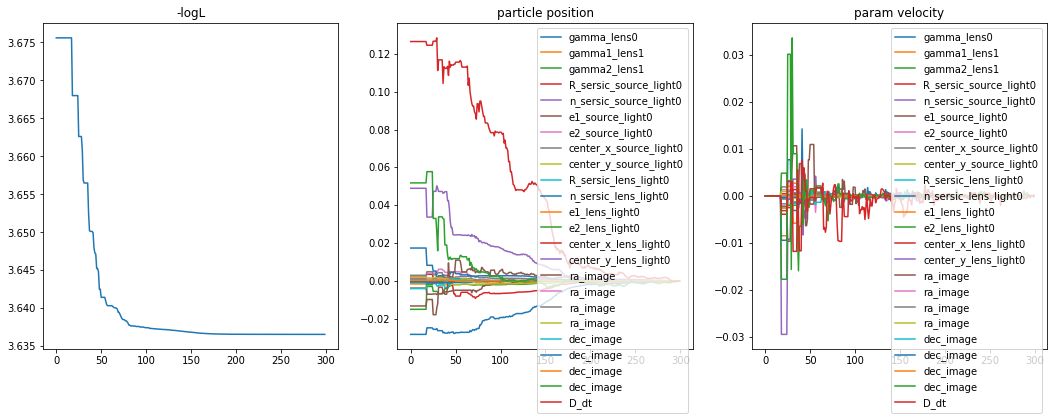

<Figure size 432x288 with 0 Axes>

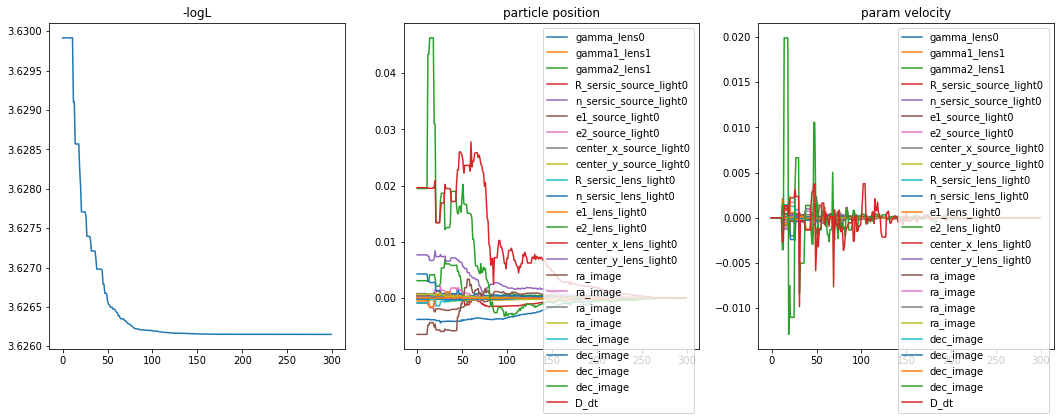

<Figure size 432x288 with 0 Axes>

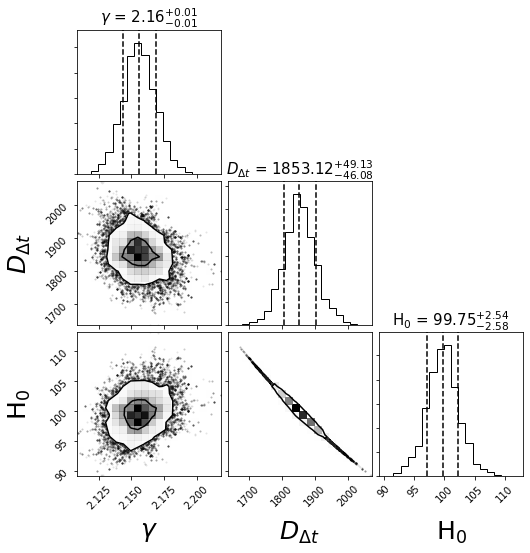

The truth values: [1.907542249079163, 2501.088570415683, 73.90726339744255]


In [8]:
# Load the pickle and print fitting result:
multi_band_list, kwargs_model, kwargs_result_best, chain_list, fix_setting, mcmc_new_list = pickle.load(open(folder+savename,'rb'))
fixed_lens, fixed_source, fixed_lens_light, fixed_ps, fixed_cosmo = fix_setting
labels_new = [r"$\gamma$", r"$D_{\Delta t}$","H$_0$" ]
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result_best, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()
#f, axes = modelPlot.plot_separate()
#f.show()
#f, axes = modelPlot.plot_subtract_from_data_all()
#f.show()
#plt.show()

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
plt.close()

true_h0 = cal_h0(z_l, z_s, TD_distance)
true_gamma = para_s[0][0]['gamma']
truths=[true_gamma,TD_distance, true_h0]	
plot = corner.corner(mcmc_new_list, labels=labels_new, show_titles=True, #range= [[0.8,1.5],[1,3],[0,1],[0, 1],[2000,5000],[20,100]], 
                      quantiles=[0.16, 0.5, 0.84], truths =truths,
                      title_kwargs={"fontsize": 15}, label_kwargs = {"fontsize": 25},
                      levels=1.0 - np.exp(-0.5 * np.array([1.,2.]) ** 2))
plt.show()

print("The truth values:", truths)